# Model Selection

## Selection Criteria: MLR

We first list selection criteria for the linear regression model $y_{i}=x_{i}^{\prime} \boldsymbol{\beta}+e_{i}$ with $\sigma^{2}=E\left(e_{i}^{2}\right)$ and a $(k+1)\times 1$ coefficient vector $\boldsymbol{\beta}$. Let $\widehat{\boldsymbol{\beta}}$ be the OLS estimator, $\widehat{e}_{i}$ the OLS residual for the $i$ observation, and $\widehat{\sigma}^{2}=n^{-1} \sum_{i=1}^{n} \widehat{e}_{i}^{2}$ be the variance estimator. The number of estimated parameters ( $\boldsymbol{\beta}$ and $\sigma^{2}$ ) is $K=k+2$.

In [1]:
import pandas as pd
import numpy as np

hprice3 = pd.read_stata('http://fmwww.bc.edu/ec-p/data/wooldridge/hprice3.dta')
hprice3['lcbd'] = np.log(hprice3.cbd)

💻 The following code estimates two linear regression models ```model1``` uses all the predictors while ```model2``` excludes ```linstsq``` and ```agesq```.

In [2]:
import patsy
f1 = 'lprice ~ lland + larea + lcbd + nbh + rooms + y81 + linst + linstsq + ldist + baths + age + agesq'
f2 = 'lprice ~ lland + larea + lcbd + nbh + rooms + y81 + linst           + ldist + baths + age        '
y1, X1 = patsy.dmatrices(f1, data=hprice3, return_type='dataframe')
y2, X2 = patsy.dmatrices(f2, data=hprice3, return_type='dataframe')

***
**_Adjusted $\bar{R}^2$_**
$$
\bar{R}^{2}=1-\left(1-R^{2}\right) \frac{n-1}{n-K-1},
$$
where $R^2$ is the standard regression coefficient of determination.

**_Bayesian Information Criterion_**
$$
\mathrm{BIC}=n+n \log \left(2 \pi \widehat{\sigma}^{2}\right)+K \log (n).
$$
**_Akaike Information Criterion_**
$$
\mathrm{AIC}=n+n \log \left(2 \pi \widehat{\sigma}^{2}\right)+2 K.
$$
***

<ins>Note</ins>: As it is often done in the _statistical learning literature_ we will use $\mathrm{BIC}$ and $\mathrm{AIC}$ defined without the additive constants $n+n\log(2\pi)$.

Therefore, we can rewrite them both as a member of a *class* of *Information Criteria*, $\mathrm{IC}$,

$$
\mathrm{IC}=n\log(\widehat{\sigma}^{2})+c(n,K).
$$

Clearly one has the $\mathrm{AIC}$ when $c=2K$ and the $\mathrm{BIC}$ when $c=K\log(n)$.

💻 Here, we load the ```OLS``` function from the ```statsmodels``` library to simply compare the overall quality of our two models:

In [3]:
from statsmodels.regression.linear_model import OLS
model1 = OLS(y1, X1).fit()
model2 = OLS(y2, X2).fit()
print(pd.DataFrame(np.array([[model1.rsquared_adj,model1.bic,model1.aic]]),
             columns=['Adj. R2', 'BIC', 'AIC']))

print(pd.DataFrame(np.array([[model2.rsquared_adj,model2.bic,model2.aic]]),
             columns=['Adj. R2', 'BIC', 'AIC']))

Adj. R2        BIC         AIC
0  0.785773 -51.593272 -100.622007
    Adj. R2        BIC        AIC
0  0.774587 -44.719943 -86.205796


💻 The first model has higher $\bar{R}^2$ and lower value for $\mathrm{BIC}$ and $\mathrm{AIC}$, so we would choose ```model1``` over ```model2```.

***
**_Mallows'_** **$C_p$**
$$
C_{p}=n \widehat{\sigma}^{2}+2 K \widetilde{\sigma}^{2},
$$
where $\widetilde{\sigma}^{2}$ is a preliminary estimator of $\sigma^{2}$ (typically based on fitting a large model, i.e., the one containing all the predictors).
***

In [4]:
## recovering sigma for models 1 and 2
sigma2_1 = model1.mse_resid
sigma2_2 = model2.mse_resid

## calculating Mallows' Cp for models 1 and 2
Cp1 = model1.nobs*sigma2_1 + 2*(model1.df_model)*sigma2_1
Cp2 = model2.nobs*sigma2_2+ 2*(model2.df_model)*sigma2_1

print(pd.DataFrame(np.array([[Cp1,Cp2]]),columns=['Model 1 Cp','Model 2 Cp']))

Model 1 Cp  Model 2 Cp
0   14.190144   14.715034


💻 In this case ```model1``` has smaller $C_p$ than ```model2```, so ```model1``` is preferred using this criteria.

***
**_Shibata_**
$$
\text{Shibata}=\widehat{\sigma}^{2}\left(1+\frac{2 K}{n}\right).
$$

**_Final Prediction Error_**
$$
\mathrm{FPE}=\widehat{\sigma}^{2}\left(\frac{1+K / n}{1-K / n}\right).
$$

**_Generalized Cross-Validation_**
$$
\mathrm{GCV}=\frac{n \widehat{\sigma}^{2}}{(n-K)^{2}}.
$$
***

In [5]:
## manually calculating Shibata, FPE, and GCV for model1
shibata1 = (sigma2_1)*(1+2*model1.df_model/model1.nobs)
FPE1 = (sigma2_1)*(1+model1.df_model/model1.nobs)/(1-model1.df_model/model1.nobs)
GCV1 = model1.nobs*(sigma2_1)/(model1.nobs-model1.df_model)**2

## manually calculating Shibata, FPE, and GCV for model2
shibata2 = (sigma2_2)*(1+2*model2.df_model/model2.nobs)
FPE2 = (sigma2_2)*(1+model2.df_model/model2.nobs)/(1-model2.df_model/model2.nobs)
GCV2 = model2.nobs*(sigma2_2)/(model2.nobs-model2.df_model)**2

print(pd.DataFrame(np.array([[shibata1,FPE1,GCV1],
                             [shibata2,FPE2,GCV2]]),
                   columns = ['Shibata','FPE','GCV']))

Shibata       FPE       GCV
0  0.044206  0.044325  0.000138
1  0.045975  0.046062  0.000144


💻 Again, the ```model1``` has smaller $\mathrm{Shibata}$, $\mathrm{FPE}$, and $\mathrm{GCV}$ than ```model2```, so ```model1``` is preferred.

***
**_Cross-Validation_**
$$
\mathrm{CV}=\frac{1}{n}\sum_{i=1}^{n} \widetilde{e}_{i}^{2},
$$
where $\widetilde{e}_{i}$ are the least squares leave-one-out prediction errors.

<ins>Prediction erros</ins>: We define the leave-one-out estimator as that obtained by applying an estimation formula to the sample omitting the $i$th observation, i.e.,

$$
\widehat{\boldsymbol{\beta}}_{(-i)}=\widehat{\boldsymbol{\beta}}-\frac{1}{\left(1-h_{i i}\right)}\left(\boldsymbol{X}^{\prime} \boldsymbol{X}\right)^{-1} \boldsymbol{x}_{i} \widehat{e}_{i},
$$

where $\widehat{e}_{i}$ are the least squares residuals and $h_{ii}$ are the [leverage](https://en.wikipedia.org/wiki/Leverage_(statistics)) values. We also define the leave-one-out residual or prediction error as that obtained using the leave-one-out regression estimator, thus

$$
\tilde{e}_{i}=y_{i}-x_{i}^{\prime} \widehat{\boldsymbol{\beta}}_{(-i)}=\left(1-h_{i i}\right)^{-1} \widehat{e}_{i}.
$$

We define the out-of-sample mean squared error as
$$
\tilde{\sigma}^{2}=\frac{1}{n} \sum_{i=1}^{n} \widetilde{e}_{i}^{2}=\frac{1}{n} \sum_{i=1}^{n}\left(1-h_{i i}\right)^{-2} \widehat{e}_{i}^{2}
$$
***

In [6]:
CV1 = (model1.resid/(1 - model1.get_influence().hat_matrix_diag))**2
CV2 = (model2.resid/(1 - model2.get_influence().hat_matrix_diag))**2
print(pd.DataFrame(np.array([[CV1.mean(),CV2.mean()]]),
                   columns=['Model 1','Model 2']))

Model 1   Model 2
0  0.044224  0.045975


💻 Again, the ```model1``` has smaller $\mathrm{CV}$ than ```model2```.

## Relationship among Selection Criteria

We first point out _three_ approximations that will be useful to see the relationships among these selection criteria:

1. $\log(1+x)\approx x$ for small $x$.
2. $(1-x)^{-1}\approx 1+x$ for small $x$.
3. $(1+x)^2\approx 1+2x$ for small $x$.

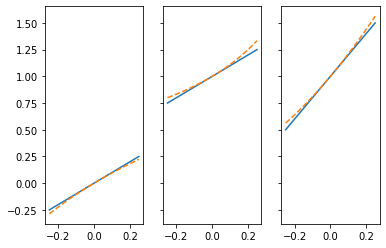

In [7]:
import matplotlib.pyplot as plt

t = np.linspace(-0.25,0.25, 100)
a1 = t
b1 = np.log(1+t)
a2 = 1 + t
b2 = 1/(1-t)
a3 = 1 + 2*t
b3 = (1 + t)**2


fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
ax1.plot(t,a1)
ax1.plot(t,b1,'--')
ax2.plot(t,a2)
ax2.plot(t,b2,'--')
ax3.plot(t,a3)
ax3.plot(t,b3,'--')

plt.show()

👉 If $\widehat{\sigma}^2=\widetilde{\sigma}^2$, then we have that $$\mathrm{Shibata}=C_p/n.$$

👉 Taking logarithms and using the approximation $\log (1+x) \simeq x$ for small $x$, we have $$n\log(\mathrm{Shibata})=n \log \left(\widehat{\sigma}^{2}\right)+n \log \left(1+\frac{2 K}{n}\right) \simeq n \log \left(\widehat{\sigma}^{2}\right)+2 K=\mathrm{AIC}$$

👉 Using the expansions $(1-x)^{-1} \simeq 1+x$ and $(1+x)^{2} \simeq 1+2 x$ we see that $$\mathrm{FPE}=\widehat{\sigma}^{2}\left(\frac{1+K / n}{1-K / n}\right)=\widehat{\sigma}^{2}\left(\frac{1}{1-K / n}\right)\left(1+\frac{K}{n}\right)\simeq\widehat{\sigma}^{2}\left(1+\frac{K}{N}\right)\left(1+\frac{K}{N}\right)\simeq\widehat{\sigma}^{2}\left(1+\frac{2 K}{n}\right)=\mathrm{Shibata}$$

👉 By the expansion $(1-x)^{-2} \simeq 1+2 x$ we find that
$$
n \mathrm{GCV}=\frac{\widehat{\sigma}^{2}}{(1-K / n)^{2}} \simeq \widehat{\sigma}^{2}\left(1+\frac{2 K}{n}\right)=\mathrm{ Shibata}.
$$

The above calculations show that the $\mathrm{AIC}$, $\mathrm{Shibata}$, $\mathrm{FPE}$, $\mathrm{GCV}$, and Mallows criterion are all close approximations to one another when $K/n$ is small. Differences arise in finite samples for large $K$.

👉 There also is a connection between $\mathrm{CV}$ and the above criteria. Again using the expansion
$(1-x)^{-2} \simeq 1+2 x$ we find that
$$
\begin{aligned} n\mathrm{CV} =\sum_{i=1}^{n}\left(1-h_{i i}\right)^{-2} \widehat{e}_{i}^{2} & \simeq \sum_{i=1}^{n} \widehat{e}_{i}^{2}+\sum_{i=1}^{n} 2 h_{i i} \widehat{e}_{i}^{2} \\ &=n \widehat{\sigma}^{2}+2 \operatorname{tr}\left(\left(X^{\prime} X\right)^{-1}\left(\sum_{i=1}^{n} x_{i} x_{i}^{\prime} \widehat{e}_{i}^{2}\right)\right) \\ & \simeq n \widehat{\sigma}^{2}+2 \text{tr}\left(\left(E\left(\boldsymbol{x}_{i} \boldsymbol{x}_{i}^{\prime}\right)\right)^{-1}\left(E\left(\boldsymbol{x}_{i} \boldsymbol{x}_{i}^{\prime} e_{i}^{2}\right)\right)\right)\\ & \simeq n \widehat{\sigma}^{2}+2 K \sigma^{2} \\ &=\mathrm{Shibata} \text{, by replacing }\sigma^2\text{ by }\widehat{\sigma}^2. \end{aligned}
$$

The third-to-last line holds asymptotically by the [WLLN](https://en.wikipedia.org/wiki/Law_of_large_numbers). The following equality holds under conditional homoskedasiticity. The final approximation replaces $\sigma^{2}$ by the estimator $\widehat{\sigma}^{2}$. This calculation shows that under the assumption of conditional homoskedasticity the $\mathrm{CV}$ criterion is similar to the other criteria. It differs under heteroskedasticity, however, which is one of its primary advantages.

## Consistent Selection

⁉️ There may be _multiple true_ models.

<ins>Example</ins>: Consider the two models $\mathscr{M}_1$: $y_{i}=x_{1 i}^{\prime} \boldsymbol{\beta}_{1}+e_{i}$ and $\mathscr{M}_2$: $y_{i}=\boldsymbol{x}_{1 i}^{\prime} \boldsymbol{\beta}_{1}+\boldsymbol{x}_{2 i}^{\prime} \boldsymbol{\beta}_{2}+e_{i}$. If $\boldsymbol{\beta}_{2} \neq 0$ then only $\mathscr{M}_2$ is true. But if $\boldsymbol{\beta}_{2}=0$ then both, $\mathscr{M}_1$ and $\mathscr{M}_2$, are true models!

We call a _model selection procedure_ **consistent** if it selects a true model (out of possibly many) in large samples.

In general, given a set of models $\overline{\mathscr{M}}=\left\{\mathscr{M}_{1}, \ldots, \mathscr{M}_{M}\right\}$, a subset $\overline{\mathscr{M}}^\ast$ are true models (as in the two linear regression models above)
while the remainder are not true models. A model selection rule $\widehat{\mathscr{M}}$ selects _one model_ from the set $\overline{\mathscr{M}}$. We say a method is consistent if it asymptotically selects a true model, i.e.,

__Definition__: A model selection rule is model selection consistent if
$$
\text{Pr}\left(\widehat{\mathscr{M}} \in \overline{\mathscr{M}}^{*}\right) \rightarrow 1
$$
as $n \rightarrow \infty$.

A major limitation with this result is that the definition of model selection consistency is _weak_. A model may be true but over parameterized. To understand the distinction consider $\mathscr{M}_{1}$ and $\mathscr{M}_{2}$ above. If $\boldsymbol{\beta}_{2}=0$ then both $\mathscr{M}_{1}$ and $\mathscr{M}_{2}$ are true, but $\mathscr{M}_{1}$ would be the preferred model as it is more parsimonious. <ins>When two nested models are both true models, it is conventional to think of the more parsimonious model as the correct model</ins>. In this context we do not describe the larger model as an incorrect model, but rather as over-parameterized. If a selection rule asymptotically selects an over-parameterized model we say that it "over-selects."

__Definition__: A model selection rule asymptotically _over-selects_ if there are
models $\mathscr{M}_{1} \subset \mathscr{M}_{2}$ such that
$$
\liminf _{n \rightarrow \infty} \text{Pr}\left(\widehat{\mathscr{M}}=\mathscr{M}_{2} | \mathscr{M}_{1}\right)>0.
$$

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Limit_superior_and_limit_inferior" style="color: #cc0000">Limit Inferior</a></p>


The definition states that over-selection occurs when two models are nested and the smaller (short)
model is true (so both models are true models but the smaller model is more parsimonious), if the larger model is asymptotically selected with positive probabilty.

### Information Criteria

<span style="color:blue">Result 1:</span> Under some regularity conditions, selection based on $\mathrm{IC}$ asymptotically over-selects if $c(n,K)=O(1)$ as $n\rightarrow\infty$.

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Big_O_notation" style="color: #cc0000">Big O Notation</a></p>

✍🏽 Clearly $c=2K=O(1)$ so the $\mathrm{AIC}$ *over-selects*.

<ins>Example</ins>: This means that if the models are $\mathscr{M}_1$: $y_{i}=x_{1 i}^{\prime} \boldsymbol{\beta}_{1}+e_{i}$ and $\mathscr{M}_2$: $y_{i}=\boldsymbol{x}_{1 i}^{\prime} \boldsymbol{\beta}_{1}+\boldsymbol{x}_{2 i}^{\prime} \boldsymbol{\beta}_{2}+e_{i}$ and $\boldsymbol{\beta}_{2}=0$ holds, then the $\mathrm{AIC}$ will select $\mathscr{M}_2$ with positive probability.

Let us now define the set of parsimonious models $\overline{\mathscr{M}}^{0} \subset \overline{\mathscr{M}}^{*}$ as the set of true models with the fewest number of parameters. When the models in $\overline{\mathscr{M}}^{*}$ are nested then $\overline{\mathscr{M}}^{0}$ will be a singleton (just one).

<ins>Example</ins>: In the regression example when $\boldsymbol{\beta}_2$, then $\mathscr{M}_1$ is the parsimonious model among $\{\mathscr{M}_1,\mathscr{M}_2\}$.

<span style="color:blue">Result 2:</span> Under some regularity conditions, selection based on $\mathrm{IC}$ is consistent for parsimonious models if for all $K_{2}>K_{1}$ as $n \rightarrow \infty$, yet $c(n, K)=o(n)$ as $n\rightarrow \infty$.

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Big_O_notation#Little-o_notation" style="color: #cc0000">Small o Notation</a></p>

✍🏽 For $\mathrm{BIC}$ one has that $c\left(n, K_{2}\right)-c\left(n, K_{1}\right)=\left(K_{2}-K_{1}\right) \log (n) \rightarrow \infty$ if $K_{2}>K_{1}$, and $c(n,K)=K\log(n)=n\times(K\cdot\log(n)/n)=o(n)$ for a fixed $K$.

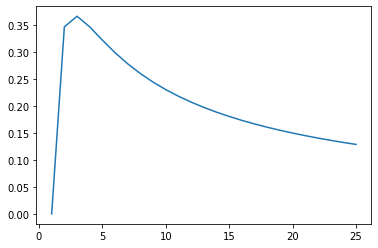

In [8]:
n = np.linspace(1,25,25)
ln = np.log(n)
plt.plot(n,ln/n)  

Therefore one can conclude that $\mathrm{BIC}$ is preferred over the other criteria if we seek to try to find the parsimonious true model.

### Asymptotic Selection Optimality

The following analysis is based on the following _homoskedastic_ regression model:

$$
\begin{array}{c}
{y_{i}=m_{i}+e_{i}}\text{,} \\
{m_{i}=\sum_{j=1}^{\infty} \mathbf{x}_{j i} \beta_{j}}\text{,} \\
{\mathbb{E}\left(e_{i} | \mathbf{x}_{i}\right)=0}\text{,} \\
{\mathbb{E}\left(e_{i}^{2} | \mathbf{x}_{i}\right)=\sigma^{2}}\text{,} \\
\end{array}
$$

where $\mathbf{x}_{i}=\left(\mathbf{x}_{1 i}, \mathbf{x}_{2 i}, \ldots\right)^\prime$.

The $K^{\text {th }}$ regression model uses the first $K$ regressors $\mathbf{x}_{K i}=\left(\mathbf{x}_{1 i}, \mathbf{x}_{2 i}, \ldots, \mathbf{x}_{K i}\right)$. The least squares estimates in matrix notation are

$$
\begin{aligned}
\mathbf{y}&=\mathbf{X}_{K} \widehat{\boldsymbol{\beta}}_{K}+\widehat{\mathbf{e}}_{K}\\
&=\widehat{\mathbf{m}}+\widehat{\mathbf{e}}_{K}\text{,}
\end{aligned}
$$

and regression fit (out-of-sample sum of expected squared prediction errors) is defined as
$$
R_{n}(K)=E\left((\widehat{\mathbf{m}}-\mathbf{m})^{\prime}(\widehat{\mathbf{m}}-\mathbf{m})|\mathbf{X}\right).
$$

Now, define the _infeasible_ optimal model $K$ which minimizes $R_{n}(K)$

$$K_{n}^{\mathrm{opt}}=\underset{K}{\text{arg min}} R_{n}(K).$$

The _infeasible_ optimal model $K_{n}^{\mathrm{opt}}$ obtains the minimized value of $R_{n}(K)$ as
$$
R_{n}^{\mathrm{opt}}=R_{n}\left(K_{n}^{\mathrm{opt}}\right)=\min _{K} R_{n}(K)
$$

Now consider model selection using the Mallow’s criterion for regression models

$$
C_{p}(K)=\widehat{e}_{K}^{\prime} \widehat{e}_{K}+2 \widetilde{\sigma}^{2} K
$$

where we explicitly index by $K$ and $\widetilde{\sigma}^{2}$ is a preliminary estimator of $\sigma^{2}$ (typically based on fitting a large model, i.e., the one containing all the predictors in your sample). Let the selected model be

$$
\widehat{K}_{n}=\underset{K}{\text{arg min}} C_{p}(K)
$$

📄 Li, Ker-Chau (1987): "Asymptotic optimality for $C_p$, $C_L$, cross-validation and generalized crossvalidation: Discrete Index Set," *Annals of Statistics*, 15, pp. 958-975.

🟥 Showed that if

1. The observations $\left(y_{i}, x_{i}\right), i=1, \ldots, n,$ are independent and identically distributed.
2. $E\left(e_{i} | \mathbf{x}_{i}\right)=0$.
3. $E\left(e_{i}^{2} | \mathbf{x}_{i}\right)=\sigma^{2}$.
4. $E\left[\left|e_{i}\right|^{4 r} | \mathbf{x}_{i}\right] \leq B<\infty$ for some $r>1$.
5. $R_{n}^{\mathrm{opt}} \rightarrow \infty$ as $n \rightarrow \infty$.
6. The estimated models are nested.

Then

$$
\frac{R_{n}(\widehat{K}_{n})}{R_{n}^{\mathrm{opt}}} \stackrel{p}{\longrightarrow} 1.
$$

This means that the selection procedure that utilizes the $C_p$ selection criterion is _asymptotically optimal_ in the sense that the prediction accuracy is asymptotically equivalent with the _infeasible_ optimum.

Condition 5 effectively states that there is no correctly specified finite-dimensional model. To see this, suppose that there is a $K<\infty$ such that the model is correctly specified, i.e., $m_{i}=\sum_{j=1}^{K} x_{j i} \beta_{j}$. In this case one has that $(\widehat{\mathbf{m}}-\mathbf{m})^{\prime}(\widehat{\mathbf{m}}-\mathbf{m})=(\widehat{\boldsymbol{\beta}}_K-\boldsymbol{\beta}_K)^\prime\mathbf{X}_K^\prime\mathbf{X}_K(\widehat{\boldsymbol{\beta}}_K-\boldsymbol{\beta}_K)$. Then by noticing that $\mathbf{X}_K^\prime\mathbf{X}_K\stackrel{p}{\longrightarrow}E(\mathbf{x}_i\mathbf{x}_i^{\prime})$ by the WLLN and recalling that the Asymptotic variance-covariance matrix (under homoskedasticity) of the OLS is $\sigma^2E(\mathbf{x}_i\mathbf{x}_i^{\prime})$ one has that $R_n(K)\approx \sigma^2(\widehat{\boldsymbol{\beta}}_K-\boldsymbol{\beta}_K)^\prime\mathbf{V}_{\widehat{\mathbf{\beta}}_K}^{-1}(\widehat{\boldsymbol{\beta}}_K-\boldsymbol{\beta}_K)\stackrel{d}{\longrightarrow}\sigma^2\chi^2(K)$ as $n\rightarrow\infty$ asymptotically and therefore $R_n(K)\approx \sigma^2\times E[\chi^2(K)]=\sigma^2K$ as $n\rightarrow\infty$ which violates condition 5 above.

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Chi-squared_distribution" style="color: #cc0000">Chi-squared Distribution</a></p>

📄 Andrews, Donald W. K. (1991c): "Asymptotic optimality of generalized $C_{L},$ cross-validation, and generalized cross-validation in regression with heteroskedastic errors," *Journal of Econometrics*, 47, pp. 359-377.

🟥 Showed that selection by $\mathrm{CV}$ satisfies the same asymptotic optimality condition _without_ requiring conditional homoskedasticity.